# Overview
This notebook illustrates the complete implementation of a YOLOv12 object detection pipeline using the Dental X-ray dataset. The project transitions from environment setup to data preprocessing, featuring automated bounding box annotation and visual verification to ensure high-quality training data for dental feature identification.
## Steps Covered
1. Environment Setup

* Updating the ultralytics framework to the latest version to utilize state-of-the-art YOLOv12 features.

2. Path Configuration

* Establishing the workspace by defining source directories for images and labels from the Dental X-ray dataset.

* Creating structured output directories in /kaggle/working/ to store processed results.

3. Automated Image Annotation

* Implementing a robust processing loop to iterate through the dataset.

* Validating label existence for each image to prevent errors during processing.

4. Coordinate Transformation

* Extracting normalized YOLO/COCO coordinates and scaling them to the actual image dimensions.

* Converting center-based coordinates into pixel-based corner coordinates for visualization.

5. Visual Decoration & Persistence

* Applying randomized colored bounding boxes and class labels directly to images using OpenCV.

* Saving the final annotated images and cloning the corresponding label files to the output directory.

6. Data Quality Verification

* Selecting a random sample of processed images and displaying them in a 2x2 grid using Matplotlib to verify the accuracy of the annotations.

## Environment Setup

In [3]:
!pip install -U ultralytics --no-deps


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00a 0:00:01


## Data Processing and Visualization

 Processing images...
 All done!
 Output directory: /kaggle/working/dental_xray_boxed


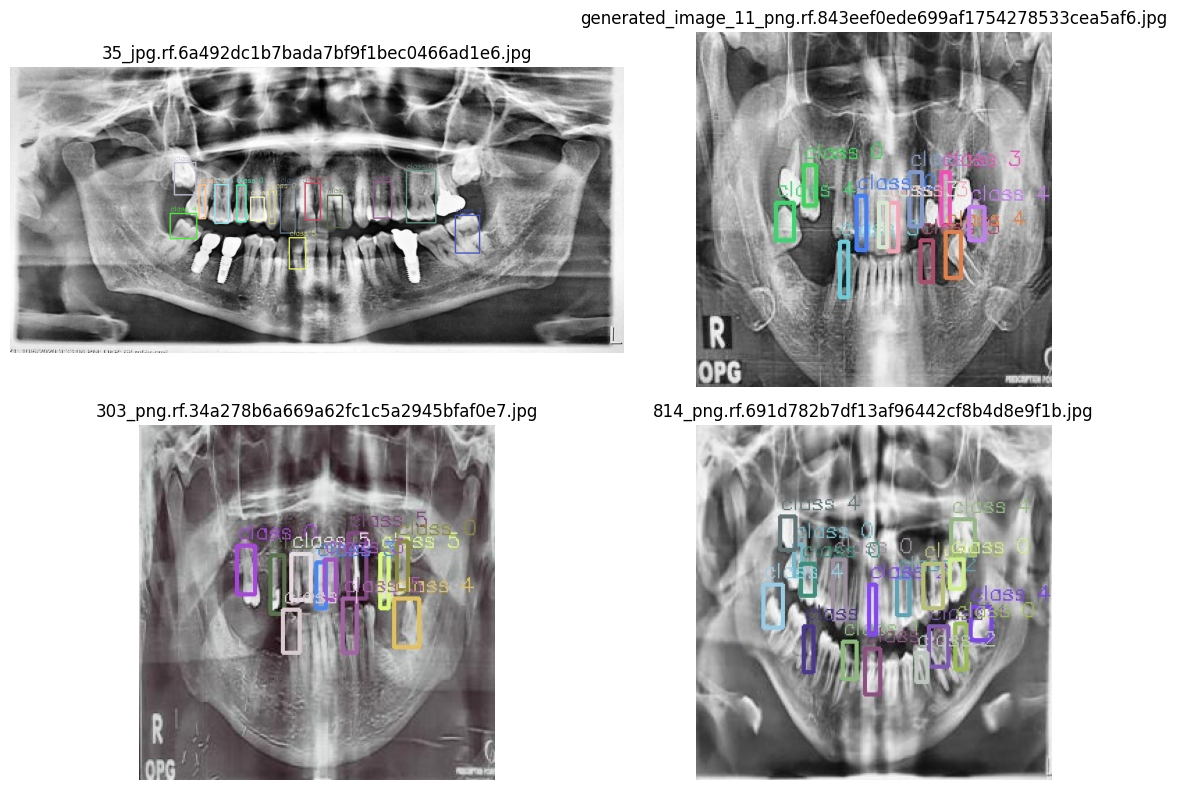

In [4]:
import os
import cv2
import random
import shutil
import matplotlib.pyplot as plt
from pathlib import Path

# Paths (from your info)

root = Path("/kaggle/input/dental-x-ray/Multi-Source Dental X-Ray Dataset Using Image-to-I/Teeth Xray Image Dataset/Teeth Xray Image Dataset/Teeth View Xray Image Dataset/Dental Xray (Ojected Detection)")
image_dir = root / "images"
label_dir = root / "labels"

# Output structure
output_root = Path("/kaggle/working/dental_xray_boxed")
output_images = output_root / "images"
output_labels = output_root / "labels"
output_images.mkdir(parents=True, exist_ok=True)
output_labels.mkdir(parents=True, exist_ok=True)


#  Random color generator

def random_color():
    return (random.randint(50, 255), random.randint(50, 255), random.randint(50, 255))


# Main loop

print(" Processing images...")

for img_file in image_dir.glob("*.jpg"):
    label_file = label_dir / f"{img_file.stem}.txt"
    if not label_file.exists():
        print(f" Missing label for {img_file.name}")
        continue

    img = cv2.imread(str(img_file))
    if img is None:
        print(f" Could not read {img_file}")
        continue

    h, w, _ = img.shape

    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:  # safety check
                continue
            cls, x_c, y_c, bw, bh = map(float, parts)
            x_c, y_c, bw, bh = x_c * w, y_c * h, bw * w, bh * h
            x1, y1 = int(x_c - bw / 2), int(y_c - bh / 2)
            x2, y2 = int(x_c + bw / 2), int(y_c + bh / 2)
            color = random_color()
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img, f"class {int(cls)}", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # Save boxed image
    save_img_path = output_images / img_file.name
    cv2.imwrite(str(save_img_path), img)

    # Copy corresponding label
    shutil.copy(label_file, output_labels / label_file.name)

print(f" All done!\n Output directory: {output_root}")


#  Show a few sample results

sample_images = list(output_images.glob("*.jpg"))[:4]
if sample_images:
    plt.figure(figsize=(12, 8))
    for i, img_path in enumerate(sample_images, 1):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 2, i)
        plt.imshow(img)
        plt.title(img_path.name)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No images found to display ")

## Setup and Initialization

In [5]:
import os
import random
import shutil
import yaml
from pathlib import Path
from tqdm import tqdm

# -----------------------------
# Paths
# -----------------------------
DATA_ROOT = Path("/kaggle/working/dental_xray_boxed")
IMG_DIR = DATA_ROOT / "images"
LBL_DIR = DATA_ROOT / "labels"

OUTPUT_ROOT = Path("/kaggle/working/dental_xray_split")
splits = ["train", "val", "test"]
split_ratios = [0.7, 0.15, 0.15]

# Create output directories
for s in splits:
    (OUTPUT_ROOT / s / "images").mkdir(parents=True, exist_ok=True)
    (OUTPUT_ROOT / s / "labels").mkdir(parents=True, exist_ok=True)

# -----------------------------
# Gather and shuffle images
# -----------------------------
valid_exts = [".jpg", ".jpeg", ".png"]
all_images = [p for p in IMG_DIR.iterdir() if p.suffix.lower() in valid_exts]
if not all_images:
    raise FileNotFoundError(f"No images found in {IMG_DIR}!")

random.shuffle(all_images)
n = len(all_images)
n_train = int(split_ratios[0] * n)
n_val = int(split_ratios[1] * n)

splits_files = {
    "train": all_images[:n_train],
    "val": all_images[n_train:n_train + n_val],
    "test": all_images[n_train + n_val:]
}

# -----------------------------
# Copy images and labels
# -----------------------------
for split_name, files in splits_files.items():
    print(f"\n Copying {split_name} set ({len(files)} images)...")
    img_out_dir = OUTPUT_ROOT / split_name / "images"
    lbl_out_dir = OUTPUT_ROOT / split_name / "labels"

    for img_path in tqdm(files, desc=f"{split_name}", ncols=80):
        shutil.copy(img_path, img_out_dir / img_path.name)
        lbl_path = LBL_DIR / f"{img_path.stem}.txt"
        if lbl_path.exists():
            shutil.copy(lbl_path, lbl_out_dir / lbl_path.name)

# -----------------------------
# Create YOLO data.yaml
# -----------------------------
data_yaml = {
    "train": str((OUTPUT_ROOT / "train" / "images").resolve()).replace("\\", "/"),
    "val": str((OUTPUT_ROOT / "val" / "images").resolve()).replace("\\", "/"),
    "test": str((OUTPUT_ROOT / "test" / "images").resolve()).replace("\\", "/"),
    "nc": 6,
    "names": [
        "BDC-BDR Teeth",
        "Caries Teeth",
        "Fractured Teeth",
        "Healthy Teeth",
        "Impacted Teeth",
        "Inflection Teeth"
    ]
}

yaml_path = OUTPUT_ROOT / "dental.yaml"
with open(yaml_path, "w") as f:
    yaml.dump(data_yaml, f, sort_keys=False)

# -----------------------------
# Done 
# -----------------------------
print("\n Dataset split completed successfully!")
print(" Split directories:")
for s in splits:
    print(f"   - {s.upper():5}: {(OUTPUT_ROOT / s).resolve()}")

print(f"\n📄 YAML file created at: {yaml_path.resolve()}")


 Copying train set (1154 images)...


train: 100%|██████████████████████████████| 1154/1154 [00:00<00:00, 3538.10it/s]



 Copying val set (247 images)...


val: 100%|██████████████████████████████████| 247/247 [00:00<00:00, 3697.37it/s]



 Copying test set (248 images)...


test: 100%|█████████████████████████████████| 248/248 [00:00<00:00, 3654.83it/s]


 Dataset split completed successfully!
 Split directories:
   - TRAIN: /kaggle/working/dental_xray_split/train
   - VAL  : /kaggle/working/dental_xray_split/val
   - TEST : /kaggle/working/dental_xray_split/test

📄 YAML file created at: /kaggle/working/dental_xray_split/dental.yaml


## Defining Dataset Paths

In [6]:
from ultralytics import YOLO
from pathlib import Path

# -----------------------------
# Paths
# -----------------------------
DATA_YAML = "/kaggle/working/dental_xray_split/dental.yaml"    # your dataset YAML
SAVE_DIR  = "/kaggle/working/yolo_output"                      # project output
PROJECT_NAME = "dental_counting"

# -----------------------------
# Load pretrained YOLOv12 model
# -----------------------------
# Nano version for Kaggle GPU
model = YOLO("yolo12n.pt")

# -----------------------------
# Train the model
# -----------------------------
model.train(
    data=DATA_YAML,
    epochs=50,           # adjust if needed
    batch=16,            # reduce if memory issues
    imgsz=640,
    project=SAVE_DIR,    # project folder
    name=PROJECT_NAME,   
    exist_ok=True,       # overwrite if folder exists
    save=True            # ensure results are saved (results.csv & plots)
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.223 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dental_xray_split/dental.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, 

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        247       2804      0.778      0.772      0.835      0.718
         BDC-BDR Teeth        214        641      0.845      0.822      0.904      0.779
          Caries Teeth        218        568      0.722      0.755      0.817      0.712
       Fractured Teeth        144        345      0.682      0.658      0.747      0.624
         Healthy Teeth        160        308      0.779      0.778      0.796      0.634
        Impacted Teeth        194        380        0.9      0.863      0.921      0.829
      Inflection Teeth        215        562      0.739      0.754      0.822       0.73
Speed: 0.2ms preprocess, 6.9ms inference, 0.0ms loss, 6.4ms postprocess per image
Results saved to /kaggle/working/yolo_output/dental_counting


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bcdb634ea90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

## Bounding Box Processing Loop

In [7]:
import pandas as pd

# Path to your YOLO results file
path = "/kaggle/working/yolo_output/dental_counting/results.csv"

# Read CSV
df = pd.read_csv(path)

# Show last few rows (contains precision/recall/mAP)
print(df.tail())

# Or just display nicely
df.style.set_caption("YOLOv8 Evaluation Results").format(precision=3)

    epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
45     46   937.702         0.56949         0.62357         0.80981   
46     47   957.580         0.56110         0.61326         0.80747   
47     48   977.448         0.56355         0.60356         0.80852   
48     49   997.264         0.56172         0.59273         0.80865   
49     50  1017.140         0.56383         0.58577         0.80733   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
45               0.77866            0.77161           0.83473   
46               0.79465            0.75879           0.83253   
47               0.77087            0.76323           0.83344   
48               0.78450            0.76241           0.83308   
49               0.78891            0.76632           0.83271   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
45              0.71840       0.56353       0.73188       0.81028  0.000109   
46              0.71603 

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,23.554,1.338,3.461,1.005,0.045,0.870,0.252,0.175,0.844,3.298,0.858,0.000,0.000,0.000
1,2,43.624,0.898,1.895,0.870,0.369,0.613,0.454,0.357,0.747,1.587,0.849,0.001,0.001,0.001
2,3,63.450,0.787,1.554,0.857,0.479,0.600,0.519,0.416,0.698,1.392,0.844,0.001,0.001,0.001
3,4,83.274,0.753,1.437,0.851,0.489,0.703,0.564,0.455,0.669,1.292,0.842,0.001,0.001,0.001
4,5,103.259,0.729,1.374,0.849,0.482,0.690,0.560,0.452,0.653,1.268,0.840,0.001,0.001,0.001
5,6,123.372,0.708,1.328,0.845,0.506,0.711,0.596,0.488,0.656,1.219,0.831,0.001,0.001,0.001
6,7,143.772,0.703,1.282,0.841,0.535,0.665,0.601,0.484,0.674,1.215,0.837,0.001,0.001,0.001
7,8,164.377,0.695,1.255,0.841,0.569,0.681,0.625,0.518,0.628,1.140,0.833,0.001,0.001,0.001
8,9,184.897,0.677,1.221,0.834,0.583,0.691,0.641,0.529,0.629,1.114,0.827,0.001,0.001,0.001
9,10,205.220,0.672,1.203,0.834,0.559,0.674,0.627,0.518,0.625,1.140,0.825,0.001,0.001,0.001


## Coordinate Conversion & Image Decoration

In [8]:
import pandas as pd
from io import StringIO

# Raw YOLO result text
data = """all        247       2804      0.778      0.772      0.835      0.718
BDC-BDR Teeth        214        641      0.845      0.822      0.904      0.779
Caries Teeth        218        568      0.722      0.755      0.817      0.712
Fractured Teeth        144        345      0.682      0.658      0.747      0.624
Healthy Teeth        160        308      0.779      0.778      0.796      0.634
Impacted Teeth        194        380        0.9      0.863      0.921      0.829
Inflection Teeth        215        562      0.739      0.754      0.822       0.73"""

# Convert into a DataFrame
df = pd.read_csv(StringIO(data), sep=r"\s{2,}", engine="python")
df.columns = ["Class", "Images", "Instances", "Precision", "Recall", "mAP50", "mAP50-95"]

# Show the DataFrame
print(df)


              Class  Images  Instances  Precision  Recall  mAP50  mAP50-95
0     BDC-BDR Teeth     214        641      0.845   0.822  0.904     0.779
1      Caries Teeth     218        568      0.722   0.755  0.817     0.712
2   Fractured Teeth     144        345      0.682   0.658  0.747     0.624
3     Healthy Teeth     160        308      0.779   0.778  0.796     0.634
4    Impacted Teeth     194        380      0.900   0.863  0.921     0.829
5  Inflection Teeth     215        562      0.739   0.754  0.822     0.730


## Data Saving and Organization

In [9]:
# -----------------------------
# 5️⃣ Print saved paths
# -----------------------------
print("✅ Training completed!")
print(
f"Logs, results.csv, plots, and weights saved at: {SAVE_DIR}/{PROJECT_NAME}")
print(f"Best weights: {SAVE_DIR}/{PROJECT_NAME}/weights/best.pt")
print(f"Final weights: {SAVE_DIR}/{PROJECT_NAME}/weights/last.pt")

✅ Training completed!
Logs, results.csv, plots, and weights saved at: /kaggle/working/yolo_output/dental_counting
Best weights: /kaggle/working/yolo_output/dental_counting/weights/best.pt
Final weights: /kaggle/working/yolo_output/dental_counting/weights/last.pt


## Final Results Visualization

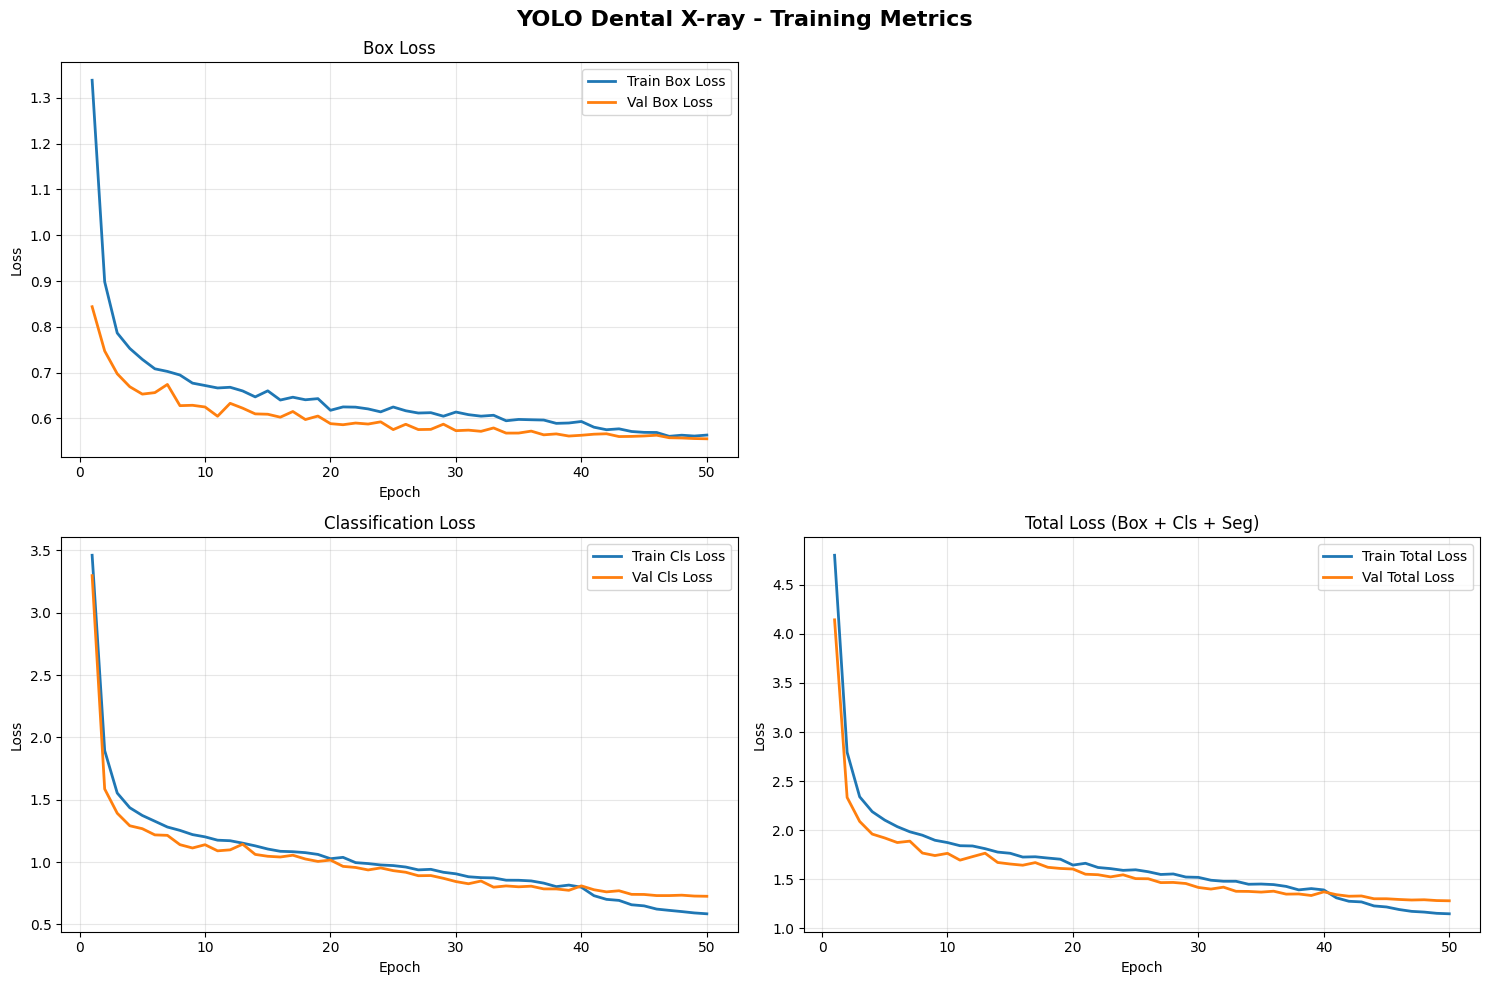

=== Final Loss Values ===
Train Box Loss: 0.5638
Val Box Loss:   0.5557
Train Cls Loss: 0.5858
Val Cls Loss:   0.7263


In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Paths
# -----------------------------
results_path = "/kaggle/working/yolo_output/dental_counting/results.csv"  # your dataset results
run_dir = "/kaggle/working/yolo_output/dental_counting"

# -----------------------------
# Check if results CSV exists
# -----------------------------
if os.path.exists(results_path):
    # Read the results CSV
    results = pd.read_csv(results_path)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('YOLO Dental X-ray - Training Metrics', fontsize=16, fontweight='bold')
    
    # Plot 1: Box Loss
    axes[0, 0].plot(results['epoch'], results['train/box_loss'], label='Train Box Loss', linewidth=2)
    axes[0, 0].plot(results['epoch'], results['val/box_loss'], label='Val Box Loss', linewidth=2)
    axes[0, 0].set_title('Box Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Segmentation Loss (if applicable)
    if 'train/seg_loss' in results.columns:
        axes[0, 1].plot(results['epoch'], results['train/seg_loss'], label='Train Seg Loss', linewidth=2)
        axes[0, 1].plot(results['epoch'], results['val/seg_loss'], label='Val Seg Loss', linewidth=2)
        axes[0, 1].set_title('Segmentation Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    else:
        axes[0, 1].axis('off')  # hide if no seg_loss

    # Plot 3: Classification Loss
    axes[1, 0].plot(results['epoch'], results['train/cls_loss'], label='Train Cls Loss', linewidth=2)
    axes[1, 0].plot(results['epoch'], results['val/cls_loss'], label='Val Cls Loss', linewidth=2)
    axes[1, 0].set_title('Classification Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Total Loss
    train_total = results['train/box_loss'] + results['train/cls_loss']
    val_total = results['val/box_loss'] + results['val/cls_loss']
    
    if 'train/seg_loss' in results.columns:
        train_total += results['train/seg_loss']
        val_total += results['val/seg_loss']
    
    axes[1, 1].plot(results['epoch'], train_total, label='Train Total Loss', linewidth=2)
    axes[1, 1].plot(results['epoch'], val_total, label='Val Total Loss', linewidth=2)
    axes[1, 1].set_title('Total Loss (Box + Cls + Seg)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # -----------------------------
    # Print final loss values
    # -----------------------------
    print("=== Final Loss Values ===")
    print(f"Train Box Loss: {results['train/box_loss'].iloc[-1]:.4f}")
    print(f"Val Box Loss:   {results['val/box_loss'].iloc[-1]:.4f}")
    print(f"Train Cls Loss: {results['train/cls_loss'].iloc[-1]:.4f}")
    print(f"Val Cls Loss:   {results['val/cls_loss'].iloc[-1]:.4f}")
    
    if 'train/seg_loss' in results.columns:
        print(f"Train Seg Loss: {results['train/seg_loss'].iloc[-1]:.4f}")
        print(f"Val Seg Loss:   {results['val/seg_loss'].iloc[-1]:.4f}")
    
else:
    print(f"Results file not found at: {results_path}")
    print("Available files in run directory:")
    if os.path.exists(run_dir):
        for file in os.listdir(run_dir):
            print(f"  - {file}")
